# Einführung in die Neuroinformatik - 7. Aufgabenblatt
## Gruppe Q: Dominik Authaler, Marco Deuscher, Carolin Schindler

### Aufgabe 1: Learning Slowdown

#### 1. Untersuchung von $\frac{\partial E}{\partial b_2}$
##### a) $\frac{\partial E}{\partial b_2}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(1,5) \cdot f(1,5) \cdot (1-f(1,5)) \approx 0,24$
##### b) $\frac{\partial E}{\partial b_2}$ mit neuen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(4) \cdot f(4) \cdot (1-f(4)) \approx 0,0347$
##### c) Welches Problem haben wir im letzten Fall und welcher Faktor ist dafür hauptsächlich verantwortlich?
Problem: Gradient sehr klein. D.h. Netzwerk lernt sehr langsam, es dauert also lange bis die Netzwerkausgabe dem Lehrersignal entspricht.  
verantwortlicher Faktor: $f'(u_2)$ mit großem $u_2$

#### 2. zwei lernende Neuronen
##### a) $\frac{\partial E}{\partial b_1}$ berechnen und argumentieren, ob das obige Problem verstärkt oder abgeschwächt wird
$\frac{\partial E}{\partial b_1} = -2\cdot (T-y_2)\cdot f'(u_2)\cdot w_2\cdot f'(u_1)$  
Das Probelm wird verstärkt, da nun $f'(u_i)$ zweimal vorkommt und somit quasi quadratisch eingeht.
##### b) Wie würde sich das Problem bei noch mehr Zwischenschichten weiterentwickeln?
Das Problem würde sich mit jeder weiteren Zwischenschicht verstärken, da mit jeder Schicht in der Ableitung der Fehlerfunktion ein weiterer Faktor $f'(u_i)$ hinzukommt.
##### c) Warum kann sich dadurch die Suche nach einem lokalen Minimum in die Länge ziehen?
Lernvorgang geht sehr langsam voran bis $u_i$ kleiner werden. Je größer also die $u_i$ zu Beginn gewählt wurden, desto länger dauert es bis die Ausgabe dem Lehrersignal entspricht.

#### 3. Untersuchung eines weiteren Problems
##### a) $\frac{\partial E}{\partial b_2}$ und $\frac{\partial E}{\partial b_1}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(0) \cdot f(0) \cdot (1-f(0)) = 0,25 $  
$\frac{\partial E}{\partial b_1} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^2 \cdot 100 = 6,25 $
##### b) Wie entwickelt sich die begonnene Folge für noch mehr Zwischenschichten?
$\frac{\partial E}{\partial b_n} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^n \cdot 100^{n-1} = (0,25)^n \cdot 100^{n-1} = \frac{(25)^n}{100} \rightarrow \infty \text{ für } n \rightarrow \infty$  
mit $n \geq 1$ Schichtnummer von Ausgang ($n=1$) zu Eingang ($n \rightarrow \infty$)
##### c) Was für ein Problem können wir nun beobachten? Warum kann dies die Suche nach einem lokalen Minimum ebenfalls erschweren?
Problem: Gradient sehr groß. D.h. Netzwerk lernt sehr schnell, es kann also passieren, dass lokale Minima (ständig) übersprungen werden.

#### 4. Inwieweit löst die cross entropy-Funktion zumindest zum Teil das hier beschriebene Problem?
$f'(u_i)$ kommt im Gradienten der cross entropy-Funktion einmal weniger vor als im Gradienten der qaudratischen Fehlerunktion. Dadurch treten die obigen Probleme weniger stark auf.


### Aufgabe 2: Flat vs. Deep Networks

#### 1. Untersuchung der Lösung $net_d$
##### a) Netzwerkausgabe für gegebene Eingabe berechnen und überprüfen
$f(x,y) = 0$  
$f((0,0), (1,1)) =(\sum_{i=1}^2 x_i\cdot y_i)\mod 2 = (0\cdot 1 + 0\cdot 1)\mod 2 = 0\mod 2 = 0$
##### b) Netzwerk für $n=3$ erweitern
Pfeile ohne Zahl sind mit $1$ gewichtet
<img src="Blatt07_Bild21b.png"> 
##### c) Welche Rolle kommt den Neuronen in der 1. und 2. Zwischenschicht jeweils zu? Welche Art Zwischenergebnis berechnen sie?
Neuronen in der 1. Zwischenschicht berechenen jeweils für ein festes $i$: $x_i \cdot y_i$.  
Neuronen in der 2. Zwischenschicht berechnen die Anzahl an Neuronen in der 1. Zwischenschicht, die eine $1$ ausgegeben haben.

#### 2. Überprüfung der Gleichung für die Anzahl an benötigten Neuronen
##### a) Erkäre, warum wir die Schwellwertfunktion in unseren Netzwerken nicht verwenden können?
Die Schwellwertfunktion ist nicht stetig und somit auch nicht differenzierbar. Dadurch können wir mit der Schwellwertfunktion als Übertragunsfunktion den Gradienten des quadratischen Fehlers nicht berechnen.
##### b) & c) & d) & e)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import itertools
import matplotlib.pyplot as plt

def genTrainingsdaten(n):
    
    comb = np.array(list(itertools.product([0,1], repeat=n)))
    xy = np.array(list(itertools.product(comb,comb)))
    T = []
    for i in range(len(xy)):
        T.append(np.dot(xy[i][0], xy[i][1])%2)
    
    xy = np.where(xy==0, -1, xy)
    T = np.where(T==0, -1, T)
    xy = xy.reshape(len(xy),len(xy[0][0])+len(xy[0][1]))
    
    return xy, T

def train_network(n_hidden, xy, T):
    """
    Trains a neural network and returns the lowest error.
    
    :param n_hidden: Number of hidden neurons to use per layer
                     (as vector to indicate when multiple hidden layers should be used).
                     Forexample, [2] uses one hidden layer with two neurons and
                     [2,2] uses two hidden layers each with two neurons.
    :return: The lowest error (MSE) occurred over all training epochs.
    """
    #Start fresh and at least try to get reproducible results
    tf.reset_default_graph()
    K.clear_session()
    tf.set_random_seed(42)
    np.random.seed(42)
    
    #dimensions
    in_dim = len(xy[0])
    out_dim = len([T[0]])
    if(len(n_hidden) == 1):
        hidden_dim = n_hidden[0]
        anz_hidden = 1
    else:
        hidden_dim = n_hidden[1]
        anz_hidden = n_hidden[0]
        
    #parameters
    initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)
    opt = tf.keras.optimizers.SGD(lr=0.2, decay=0.0001, momentum=0.9,nesterov=True) #lr=0.01
    act = 'tanh'
    model = tf.keras.models.Sequential()
    
    #hidden layer with input
    model.add(tf.keras.layers.Dense(input_dim=in_dim,
                                 units=hidden_dim,
                                 activation=act,
                                 kernel_initializer = initializer))   
    #hidden layers
    for i in range(1, anz_hidden):
        model.add(tf.keras.layers.Dense(units=hidden_dim,
                                     activation=act,
                                     kernel_initializer = initializer))  
    #output layer
    model.add(tf.keras.layers.Dense(units=out_dim,
                                 activation=act))
    
    #compile
    model.compile(optimizer = opt, loss='mse')
    #training
    history = model.fit(xy, T, epochs=300, batch_size=len(T))
    
    return min(history.history['loss'])

n=3
xy, T = genTrainingsdaten(n)
neurons_flat = []
minloss_flat = []
neurons_deep = []
minloss_deep = []

for i in range(1, 2**(n+1)+4+1):
    neurons_flat.append(i+1)
    minloss_flat.append(train_network([i], xy, T))
for i in range(1, (n+1)+4+1):
    neurons_deep.append(i*2+1)
    minloss_deep.append(train_network([2, i], xy, T))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.5134
Epoch 2/300
64/64 [==============================] - 0s 222us/sample - loss: 0.2880
Epoch 3/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2553
Epoch 4/300
64/64 [==============================] - 0s 19us/sample - loss: 0.2684
Epoch 5/300
64/64 [==============================] - 0s 34us/sample - loss: 0.2744
Epoch 6/300
64/64 [==============================] - 0s 34us/sample - loss: 0.2678
Epoch 7/300
64/64 [==============================] - 0s 33us/sample - loss: 0.2535
Epoch 8/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2413
Epoch 9/300
64/64 [==============================] - 0s 17us/sample - loss: 0.2384
Epoch 10/300
64/64 [==============================] - 0s 46us/sample - loss: 0.2392
E

Epoch 89/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1968
Epoch 90/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1967
Epoch 91/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1967
Epoch 92/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1967
Epoch 93/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1967
Epoch 94/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1967
Epoch 95/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1967
Epoch 96/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1967
Epoch 97/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1967
Epoch 98/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1967
Epoch 99/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1966
Epoch 100/300
64/64 [==============================] - 0s 47us/sample - loss: 0.

Epoch 186/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1962
Epoch 187/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1962
Epoch 188/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1962
Epoch 189/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1962
Epoch 190/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1962
Epoch 191/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1962
Epoch 192/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1962
Epoch 193/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1961
Epoch 194/300
64/64 [==============================] - 0s 76us/sample - loss: 0.1961
Epoch 195/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1961
Epoch 196/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1961
Epoch 197/300
64/64 [==============================] - 0s 36us/samp

Epoch 283/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1960
Epoch 284/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1960
Epoch 285/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 286/300
64/64 [==============================] - 0s 45us/sample - loss: 0.1960
Epoch 287/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1960
Epoch 288/300
64/64 [==============================] - 0s 14us/sample - loss: 0.1960
Epoch 289/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 290/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1960
Epoch 291/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 292/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1960
Epoch 293/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1960
Epoch 294/300
64/64 [==============================] - 0s 31us/sa

Epoch 81/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1959
Epoch 82/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1959
Epoch 83/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1959
Epoch 84/300
64/64 [==============================] - 0s 21us/sample - loss: 0.1959
Epoch 85/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1958
Epoch 86/300
64/64 [==============================] - 0s 50us/sample - loss: 0.1958
Epoch 87/300
64/64 [==============================] - 0s 15us/sample - loss: 0.1958
Epoch 88/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1958
Epoch 89/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1958
Epoch 90/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1957
Epoch 91/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1957
Epoch 92/300
64/64 [==============================] - 0s 64us/sample - loss:

Epoch 178/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1834
Epoch 179/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1831
Epoch 180/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1828
Epoch 181/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1824
Epoch 182/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1821
Epoch 183/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1817
Epoch 184/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1813
Epoch 185/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1809
Epoch 186/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1805
Epoch 187/300
64/64 [==============================] - 0s 83us/sample - loss: 0.1801
Epoch 188/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1797
Epoch 189/300
64/64 [==============================] - 0s 31us/samp

Epoch 275/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1496
Epoch 276/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1495
Epoch 277/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1494
Epoch 278/300
64/64 [==============================] - 0s 19us/sample - loss: 0.1493
Epoch 279/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1492
Epoch 280/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1491
Epoch 281/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1490
Epoch 282/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1489
Epoch 283/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1488
Epoch 284/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1487
Epoch 285/300
64/64 [==============================] - 0s 44us/sample - loss: 0.1486
Epoch 286/300
64/64 [==============================] - 0s 31us/sa

Epoch 73/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1936
Epoch 74/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1934
Epoch 75/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1932
Epoch 76/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1930
Epoch 77/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1928
Epoch 78/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1925
Epoch 79/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1923
Epoch 80/300
64/64 [==============================] - 0s 66us/sample - loss: 0.1920
Epoch 81/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1917
Epoch 82/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1915
Epoch 83/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1912
Epoch 84/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 170/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1425
Epoch 171/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1422
Epoch 172/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1418
Epoch 173/300
64/64 [==============================] - 0s 67us/sample - loss: 0.1414
Epoch 174/300
64/64 [==============================] - 0s 4us/sample - loss: 0.1410
Epoch 175/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1405
Epoch 176/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1400
Epoch 177/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1394
Epoch 178/300
64/64 [==============================] - 0s 57us/sample - loss: 0.1388
Epoch 179/300
64/64 [==============================] - 0s 54us/sample - loss: 0.1381
Epoch 180/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1373
Epoch 181/300
64/64 [==============================] - 0s 41us/sampl

Epoch 267/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0714
Epoch 268/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0713
Epoch 269/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0712
Epoch 270/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0711
Epoch 271/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0710
Epoch 272/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0709
Epoch 273/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0708
Epoch 274/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0708
Epoch 275/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0707
Epoch 276/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0706
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0705
Epoch 278/300
64/64 [==============================] - 0s 33us/sa

Epoch 65/300
64/64 [==============================] - 0s 63us/sample - loss: 0.1377
Epoch 66/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1352
Epoch 67/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1325
Epoch 68/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1298
Epoch 69/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1271
Epoch 70/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1243
Epoch 71/300
64/64 [==============================] - 0s 43us/sample - loss: 0.1216
Epoch 72/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1189
Epoch 73/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1163
Epoch 74/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1137
Epoch 75/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1113
Epoch 76/300
64/64 [==============================] - 0s 69us/sample - loss: 0

Epoch 162/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0441
Epoch 163/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0440
Epoch 164/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0439
Epoch 165/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0437
Epoch 166/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0436
Epoch 167/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0435
Epoch 168/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0434
Epoch 169/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0433
Epoch 170/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0432
Epoch 171/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0431
Epoch 172/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0430
Epoch 173/300
64/64 [==============================] - 0s 34us/sa

Epoch 259/300
64/64 [==============================] - 0s 61us/sample - loss: 0.0363
Epoch 260/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0361
Epoch 261/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0360
Epoch 262/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0358
Epoch 263/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0356
Epoch 264/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0354
Epoch 265/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0352
Epoch 266/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0349
Epoch 267/300
64/64 [==============================] - 0s 66us/sample - loss: 0.0346
Epoch 268/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0343
Epoch 269/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0340
Epoch 270/300
64/64 [==============================] - 0s 32us/sa

Epoch 57/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0932
Epoch 58/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0891
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0851
Epoch 60/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0812
Epoch 61/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0775
Epoch 62/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0739
Epoch 63/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0706
Epoch 64/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0675
Epoch 65/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0647
Epoch 66/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0622
Epoch 67/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0599
Epoch 68/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 155/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0103
Epoch 156/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0101
Epoch 157/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0099
Epoch 158/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0097
Epoch 159/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0095
Epoch 160/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0093
Epoch 161/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0091
Epoch 162/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0089
Epoch 163/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0088
Epoch 164/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0086
Epoch 165/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0084
Epoch 166/300
64/64 [==============================] - 0s 16us/samp

Epoch 252/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0098
Epoch 253/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0099
Epoch 254/300
64/64 [==============================] - 0s 75us/sample - loss: 0.0100
Epoch 255/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0100
Epoch 256/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0101
Epoch 257/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0101
Epoch 258/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0101
Epoch 259/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0101
Epoch 260/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0100
Epoch 261/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0100
Epoch 262/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0099
Epoch 263/300
64/64 [==============================] - 0s 44us/sa

Epoch 50/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0856
Epoch 51/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0799
Epoch 52/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0741
Epoch 53/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0684
Epoch 54/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0632
Epoch 55/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0587
Epoch 56/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0547
Epoch 57/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0513
Epoch 58/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0481
Epoch 59/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0452
Epoch 60/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0424
Epoch 61/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 148/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0168
Epoch 149/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0168
Epoch 150/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0168
Epoch 151/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0168
Epoch 152/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0168
Epoch 153/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0168
Epoch 154/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0168
Epoch 155/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0167
Epoch 156/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 157/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0167
Epoch 158/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 159/300
64/64 [==============================] - 0s 16us/sa

Epoch 245/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 246/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0161
Epoch 247/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0161
Epoch 248/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 249/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0161
Epoch 250/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0161
Epoch 251/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 252/300
64/64 [==============================] - 0s 58us/sample - loss: 0.0161
Epoch 253/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0161
Epoch 254/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 255/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 256/300
64/64 [==============================] - 0s 0s/samp

Epoch 43/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1605
Epoch 44/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1578
Epoch 45/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1551
Epoch 46/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1523
Epoch 47/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1494
Epoch 48/300
64/64 [==============================] - 0s 83us/sample - loss: 0.1464
Epoch 49/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1433
Epoch 50/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1402
Epoch 51/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1371
Epoch 52/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1339
Epoch 53/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1306
Epoch 54/300
64/64 [==============================] - 0s 44us/sample - loss: 0

Epoch 141/300
64/64 [==============================] - 0s 74us/sample - loss: 0.0173
Epoch 142/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0173
Epoch 143/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0173
Epoch 144/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0172
Epoch 145/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0172
Epoch 146/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0172
Epoch 147/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0172
Epoch 148/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0171
Epoch 149/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0171
Epoch 150/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0171
Epoch 151/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0171
Epoch 152/300
64/64 [==============================] - 0s 16us/samp

Epoch 238/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0162
Epoch 239/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0162
Epoch 240/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0162
Epoch 241/300
64/64 [==============================] - 0s 106us/sample - loss: 0.0162
Epoch 242/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0162
Epoch 243/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0162
Epoch 244/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0162
Epoch 245/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0162
Epoch 246/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0162
Epoch 247/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0162
Epoch 248/300
64/64 [==============================] - 0s 528us/sample - loss: 0.0162
Epoch 249/300
64/64 [==============================] - 0s 31us/sa

Epoch 36/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1871
Epoch 37/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1851
Epoch 38/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1829
Epoch 39/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1805
Epoch 40/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1780
Epoch 41/300
64/64 [==============================] - 0s 15us/sample - loss: 0.1753
Epoch 42/300
64/64 [==============================] - 0s 69us/sample - loss: 0.1725
Epoch 43/300
64/64 [==============================] - 0s 11us/sample - loss: 0.1695
Epoch 44/300
64/64 [==============================] - 0s 18us/sample - loss: 0.1664
Epoch 45/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1631
Epoch 46/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1597
Epoch 47/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1

Epoch 134/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0063
Epoch 135/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0061
Epoch 136/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0059
Epoch 137/300
64/64 [==============================] - 0s 14us/sample - loss: 0.0057
Epoch 138/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0056
Epoch 139/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0054
Epoch 140/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0053
Epoch 141/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0051
Epoch 142/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0050
Epoch 143/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0048
Epoch 144/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0047
Epoch 145/300
64/64 [==============================] - 0s 62us/samp

Epoch 230/300
64/64 [==============================] - 0s 16us/sample - loss: 8.5077e-04
Epoch 231/300
64/64 [==============================] - 0s 66us/sample - loss: 8.4132e-04
Epoch 232/300
64/64 [==============================] - 0s 21us/sample - loss: 8.3208e-04
Epoch 233/300
64/64 [==============================] - 0s 39us/sample - loss: 8.2305e-04
Epoch 234/300
64/64 [==============================] - 0s 18us/sample - loss: 8.1421e-04
Epoch 235/300
64/64 [==============================] - 0s 16us/sample - loss: 8.0556e-04
Epoch 236/300
64/64 [==============================] - 0s 31us/sample - loss: 7.9710e-04
Epoch 237/300
64/64 [==============================] - 0s 22us/sample - loss: 7.8882e-04
Epoch 238/300
64/64 [==============================] - 0s 23us/sample - loss: 7.8071e-04
Epoch 239/300
64/64 [==============================] - 0s 35us/sample - loss: 7.7278e-04
Epoch 240/300
64/64 [==============================] - 0s 32us/sample - loss: 7.6501e-04
Epoch 241/300
64/64 [

Epoch 24/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2070
Epoch 25/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2061
Epoch 26/300
64/64 [==============================] - 0s 34us/sample - loss: 0.2050
Epoch 27/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2040
Epoch 28/300
64/64 [==============================] - 0s 25us/sample - loss: 0.2029
Epoch 29/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2020
Epoch 30/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2010
Epoch 31/300
64/64 [==============================] - 0s 21us/sample - loss: 0.2001
Epoch 32/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1991
Epoch 33/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1980
Epoch 34/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1969
Epoch 35/300
64/64 [==============================] - 0s 16us/sample - loss: 0

Epoch 122/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0103
Epoch 123/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0101
Epoch 124/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0098
Epoch 125/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0096
Epoch 126/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0094
Epoch 127/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0092
Epoch 128/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0089
Epoch 129/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0087
Epoch 130/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0085
Epoch 131/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0083
Epoch 132/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0081
Epoch 133/300
64/64 [==============================] - 0s 25us/samp

Epoch 219/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0012
Epoch 220/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0012
Epoch 221/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0012
Epoch 222/300
64/64 [==============================] - 0s 80us/sample - loss: 0.0012
Epoch 223/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0012
Epoch 224/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 225/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0011
Epoch 226/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0011
Epoch 227/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0011
Epoch 228/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0011
Epoch 229/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0011
Epoch 230/300
64/64 [==============================] - 0s 43us/samp

Epoch 13/300
64/64 [==============================] - 0s 40us/sample - loss: 0.2025
Epoch 14/300
64/64 [==============================] - 0s 20us/sample - loss: 0.2028
Epoch 15/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1983
Epoch 16/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1929
Epoch 17/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1888
Epoch 18/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1859
Epoch 19/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1836
Epoch 20/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1813
Epoch 21/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1786
Epoch 22/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1756
Epoch 23/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1724
Epoch 24/300
64/64 [==============================] - 0s 31us/sample - loss: 0

Epoch 111/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0033
Epoch 112/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0031
Epoch 113/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0030
Epoch 114/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0029
Epoch 115/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0028
Epoch 116/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0028
Epoch 117/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0027
Epoch 118/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 119/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0025
Epoch 120/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0025
Epoch 121/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0024
Epoch 122/300
64/64 [==============================] - 0s 20us/sa

Epoch 207/300
64/64 [==============================] - 0s 16us/sample - loss: 8.3048e-04
Epoch 208/300
64/64 [==============================] - 0s 0s/sample - loss: 8.2386e-04
Epoch 209/300
64/64 [==============================] - 0s 0s/sample - loss: 8.1734e-04
Epoch 210/300
64/64 [==============================] - 0s 37us/sample - loss: 8.1089e-04
Epoch 211/300
64/64 [==============================] - 0s 37us/sample - loss: 8.0454e-04
Epoch 212/300
64/64 [==============================] - 0s 31us/sample - loss: 7.9826e-04
Epoch 213/300
64/64 [==============================] - 0s 32us/sample - loss: 7.9206e-04
Epoch 214/300
64/64 [==============================] - 0s 21us/sample - loss: 7.8593e-04
Epoch 215/300
64/64 [==============================] - 0s 39us/sample - loss: 7.7988e-04
Epoch 216/300
64/64 [==============================] - 0s 16us/sample - loss: 7.7391e-04
Epoch 217/300
64/64 [==============================] - 0s 28us/sample - loss: 7.6801e-04
Epoch 218/300
64/64 [====

Epoch 300/300
64/64 [==============================] - 0s 36us/sample - loss: 4.4388e-04
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.8733
Epoch 2/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3528
Epoch 3/300
64/64 [==============================] - 0s 71us/sample - loss: 0.2686
Epoch 4/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2676
Epoch 5/300
64/64 [==============================] - 0s 35us/sample - loss: 0.2803
Epoch 6/300
64/64 [==============================] - 0s 36us/sample - loss: 0.2873
Epoch 7/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2851
Epoch 8/300
64/64 [==============================] - 0s 53us/sample - loss: 0.2789
Epoch 9/300
64/64 [==============================] - 0s 49us/sample - loss: 0.2711
Epoch 10/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2618
Epoch 11/300
64/64 [==============================] - 0s 39us/sample - loss: 0.25

Epoch 98/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0059
Epoch 99/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0056
Epoch 100/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0053
Epoch 101/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0050
Epoch 102/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0048
Epoch 103/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0046
Epoch 104/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0044
Epoch 105/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0042
Epoch 106/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0040
Epoch 107/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0038
Epoch 108/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0036
Epoch 109/300
64/64 [==============================] - 0s 33us/samp

Epoch 193/300
64/64 [==============================] - 0s 46us/sample - loss: 7.0427e-04
Epoch 194/300
64/64 [==============================] - 0s 50us/sample - loss: 6.9819e-04
Epoch 195/300
64/64 [==============================] - 0s 30us/sample - loss: 6.9222e-04
Epoch 196/300
64/64 [==============================] - 0s 18us/sample - loss: 6.8635e-04
Epoch 197/300
64/64 [==============================] - 0s 28us/sample - loss: 6.8058e-04
Epoch 198/300
64/64 [==============================] - 0s 31us/sample - loss: 6.7490e-04
Epoch 199/300
64/64 [==============================] - 0s 17us/sample - loss: 6.6932e-04
Epoch 200/300
64/64 [==============================] - 0s 31us/sample - loss: 6.6383e-04
Epoch 201/300
64/64 [==============================] - 0s 27us/sample - loss: 6.5843e-04
Epoch 202/300
64/64 [==============================] - 0s 16us/sample - loss: 6.5312e-04
Epoch 203/300
64/64 [==============================] - 0s 32us/sample - loss: 6.4789e-04
Epoch 204/300
64/64 [

Epoch 286/300
64/64 [==============================] - 0s 16us/sample - loss: 3.8592e-04
Epoch 287/300
64/64 [==============================] - 0s 36us/sample - loss: 3.8399e-04
Epoch 288/300
64/64 [==============================] - 0s 49us/sample - loss: 3.8208e-04
Epoch 289/300
64/64 [==============================] - 0s 43us/sample - loss: 3.8018e-04
Epoch 290/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7830e-04
Epoch 291/300
64/64 [==============================] - 0s 31us/sample - loss: 3.7644e-04
Epoch 292/300
64/64 [==============================] - 0s 33us/sample - loss: 3.7460e-04
Epoch 293/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7277e-04
Epoch 294/300
64/64 [==============================] - 0s 29us/sample - loss: 3.7096e-04
Epoch 295/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6916e-04
Epoch 296/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6738e-04
Epoch 297/300
64/64 [

Epoch 83/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0360
Epoch 84/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0347
Epoch 85/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0334
Epoch 86/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0322
Epoch 87/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0309
Epoch 88/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0298
Epoch 89/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0286
Epoch 90/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0276
Epoch 91/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0266
Epoch 92/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0257
Epoch 93/300
64/64 [==============================] - 0s 67us/sample - loss: 0.0249
Epoch 94/300
64/64 [==============================] - 0s 21us/sample - loss:

Epoch 180/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0167
Epoch 181/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0167
Epoch 182/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0167
Epoch 183/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0167
Epoch 184/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 185/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0167
Epoch 186/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0166
Epoch 187/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0166
Epoch 188/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0166
Epoch 189/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0166
Epoch 190/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0166
Epoch 191/300
64/64 [==============================] - 0s 0s/sample -

Epoch 277/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 279/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0161
Epoch 280/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 281/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 282/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 283/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0161
Epoch 284/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0161
Epoch 285/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0161
Epoch 286/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 287/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 288/300
64/64 [==============================] - 0s 37us/samp

Epoch 75/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0510
Epoch 76/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0497
Epoch 77/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0482
Epoch 78/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0468
Epoch 79/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0452
Epoch 80/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0436
Epoch 81/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0420
Epoch 82/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0403
Epoch 83/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0385
Epoch 84/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0368
Epoch 85/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0350
Epoch 86/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 172/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0013
Epoch 173/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0013
Epoch 174/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 175/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 176/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0012
Epoch 177/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 178/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 179/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0012
Epoch 180/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0012
Epoch 181/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0012
Epoch 182/300
64/64 [==============================] - 0s 85us/sample - loss: 0.0011
Epoch 183/300
64/64 [==============================] - 0s 23us/sample

Epoch 266/300
64/64 [==============================] - 0s 73us/sample - loss: 0.0115
Epoch 267/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0113
Epoch 268/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0112
Epoch 269/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0108
Epoch 270/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0105
Epoch 271/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0101
Epoch 272/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0097
Epoch 273/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0093
Epoch 274/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0089
Epoch 275/300
64/64 [==============================] - 0s 66us/sample - loss: 0.0084
Epoch 276/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0080
Epoch 277/300
64/64 [==============================] - 0s 42us/samp

Epoch 64/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 65/300
64/64 [==============================] - 0s 97us/sample - loss: 0.0175
Epoch 66/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0160
Epoch 67/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0147
Epoch 68/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0136
Epoch 69/300
64/64 [==============================] - 0s 94us/sample - loss: 0.0126
Epoch 70/300
64/64 [==============================] - 0s 77us/sample - loss: 0.0117
Epoch 71/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0109
Epoch 72/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0101
Epoch 73/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0093
Epoch 74/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0085
Epoch 75/300
64/64 [==============================] - 0s 33us/sample - loss: 0

Epoch 160/300
64/64 [==============================] - 0s 16us/sample - loss: 7.3432e-04
Epoch 161/300
64/64 [==============================] - 0s 16us/sample - loss: 7.2625e-04
Epoch 162/300
64/64 [==============================] - 0s 31us/sample - loss: 7.1835e-04
Epoch 163/300
64/64 [==============================] - 0s 0s/sample - loss: 7.1061e-04
Epoch 164/300
64/64 [==============================] - 0s 31us/sample - loss: 7.0303e-04
Epoch 165/300
64/64 [==============================] - 0s 25us/sample - loss: 6.9561e-04
Epoch 166/300
64/64 [==============================] - 0s 63us/sample - loss: 6.8834e-04
Epoch 167/300
64/64 [==============================] - 0s 35us/sample - loss: 6.8121e-04
Epoch 168/300
64/64 [==============================] - 0s 16us/sample - loss: 6.7422e-04
Epoch 169/300
64/64 [==============================] - 0s 23us/sample - loss: 6.6737e-04
Epoch 170/300
64/64 [==============================] - 0s 16us/sample - loss: 6.6066e-04
Epoch 171/300
64/64 [==

64/64 [==============================] - 0s 31us/sample - loss: 3.5853e-04
Epoch 253/300
64/64 [==============================] - 0s 37us/sample - loss: 3.5650e-04
Epoch 254/300
64/64 [==============================] - 0s 33us/sample - loss: 3.5450e-04
Epoch 255/300
64/64 [==============================] - 0s 29us/sample - loss: 3.5253e-04
Epoch 256/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5057e-04
Epoch 257/300
64/64 [==============================] - 0s 64us/sample - loss: 3.4863e-04
Epoch 258/300
64/64 [==============================] - 0s 473us/sample - loss: 3.4672e-04
Epoch 259/300
64/64 [==============================] - 0s 48us/sample - loss: 3.4482e-04
Epoch 260/300
64/64 [==============================] - 0s 47us/sample - loss: 3.4295e-04
Epoch 261/300
64/64 [==============================] - 0s 33us/sample - loss: 3.4109e-04
Epoch 262/300
64/64 [==============================] - 0s 31us/sample - loss: 3.3926e-04
Epoch 263/300
64/64 [=============

Epoch 48/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1064
Epoch 49/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1030
Epoch 50/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0996
Epoch 51/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0961
Epoch 52/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0926
Epoch 53/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0891
Epoch 54/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0857
Epoch 55/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0822
Epoch 56/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0789
Epoch 57/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0757
Epoch 58/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0727
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 146/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0029
Epoch 147/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0028
Epoch 148/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0027
Epoch 149/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0026
Epoch 150/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 151/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0025
Epoch 152/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0025
Epoch 153/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0024
Epoch 154/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0023
Epoch 155/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0023
Epoch 156/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0022
Epoch 157/300
64/64 [==============================] - 0s 16us/sa

Epoch 241/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0011
Epoch 242/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 243/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0016
Epoch 244/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0021
Epoch 245/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0028
Epoch 246/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0038
Epoch 247/300
64/64 [==============================] - 0s 64us/sample - loss: 0.0051
Epoch 248/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0070
Epoch 249/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0091
Epoch 250/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0117
Epoch 251/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0138
Epoch 252/300
64/64 [==============================] - 0s 31us/sa

Epoch 39/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1255
Epoch 40/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1197
Epoch 41/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1138
Epoch 42/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1080
Epoch 43/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1021
Epoch 44/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0962
Epoch 45/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0903
Epoch 46/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0843
Epoch 47/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0784
Epoch 48/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0725
Epoch 49/300
64/64 [==============================] - 0s 73us/sample - loss: 0.0667
Epoch 50/300
64/64 [==============================] - 0s 63us/sample - loss: 0

Epoch 137/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0022
Epoch 138/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0022
Epoch 139/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0021
Epoch 140/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0020
Epoch 141/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0020
Epoch 142/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0019
Epoch 143/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0019
Epoch 144/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 145/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 146/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0017
Epoch 147/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0017
Epoch 148/300
64/64 [==============================] - 0s 31us/samp

Epoch 231/300
64/64 [==============================] - 0s 31us/sample - loss: 5.0163e-04
Epoch 232/300
64/64 [==============================] - 0s 33us/sample - loss: 4.9747e-04
Epoch 233/300
64/64 [==============================] - 0s 47us/sample - loss: 4.9337e-04
Epoch 234/300
64/64 [==============================] - 0s 47us/sample - loss: 4.8934e-04
Epoch 235/300
64/64 [==============================] - 0s 48us/sample - loss: 4.8538e-04
Epoch 236/300
64/64 [==============================] - 0s 28us/sample - loss: 4.8147e-04
Epoch 237/300
64/64 [==============================] - 0s 16us/sample - loss: 4.7763e-04
Epoch 238/300
64/64 [==============================] - 0s 16us/sample - loss: 4.7385e-04
Epoch 239/300
64/64 [==============================] - 0s 31us/sample - loss: 4.7013e-04
Epoch 240/300
64/64 [==============================] - 0s 34us/sample - loss: 4.6646e-04
Epoch 241/300
64/64 [==============================] - 0s 38us/sample - loss: 4.6286e-04
Epoch 242/300
64/64 [

Epoch 25/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1717
Epoch 26/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1686
Epoch 27/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1653
Epoch 28/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1620
Epoch 29/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1587
Epoch 30/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1553
Epoch 31/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1519
Epoch 32/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1483
Epoch 33/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1447
Epoch 34/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1409
Epoch 35/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1372
Epoch 36/300
64/64 [==============================] - 0s 34us/sample - loss: 0

Epoch 123/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0014
Epoch 124/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0014
Epoch 125/300
64/64 [==============================] - 0s 20us/sample - loss: 0.0013
Epoch 126/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0013
Epoch 127/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 128/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0013
Epoch 129/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0012
Epoch 130/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0012
Epoch 131/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0012
Epoch 132/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0012
Epoch 133/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 134/300
64/64 [==============================] - 0s 47us/sa

Epoch 216/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0010
Epoch 217/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 218/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0015
Epoch 219/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0019
Epoch 220/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0024
Epoch 221/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0030
Epoch 222/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0038
Epoch 223/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0048
Epoch 224/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0060
Epoch 225/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0072
Epoch 226/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0086
Epoch 227/300
64/64 [==============================] - 0s 37us/samp

Epoch 12/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2297
Epoch 13/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2170
Epoch 14/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2054
Epoch 15/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1974
Epoch 16/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1944
Epoch 17/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1947
Epoch 18/300
64/64 [==============================] - 0s 93us/sample - loss: 0.1951
Epoch 19/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1945
Epoch 20/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1930
Epoch 21/300
64/64 [==============================] - 0s 42us/sample - loss: 0.1908
Epoch 22/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1876
Epoch 23/300
64/64 [==============================] - 0s 26us/sample - loss:

Epoch 110/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0018
Epoch 111/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0017
Epoch 112/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0017
Epoch 113/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0016
Epoch 114/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0016
Epoch 115/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0015
Epoch 116/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0015
Epoch 117/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0015
Epoch 118/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0014
Epoch 119/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0014
Epoch 120/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0013
Epoch 121/300
64/64 [==============================] - 0s 0s/sample

Epoch 204/300
64/64 [==============================] - 0s 0s/sample - loss: 4.7868e-04
Epoch 205/300
64/64 [==============================] - 0s 88us/sample - loss: 4.7516e-04
Epoch 206/300
64/64 [==============================] - 0s 45us/sample - loss: 4.7169e-04
Epoch 207/300
64/64 [==============================] - 0s 31us/sample - loss: 4.6827e-04
Epoch 208/300
64/64 [==============================] - 0s 29us/sample - loss: 4.6489e-04
Epoch 209/300
64/64 [==============================] - 0s 23us/sample - loss: 4.6157e-04
Epoch 210/300
64/64 [==============================] - 0s 31us/sample - loss: 4.5829e-04
Epoch 211/300
64/64 [==============================] - 0s 35us/sample - loss: 4.5506e-04
Epoch 212/300
64/64 [==============================] - 0s 31us/sample - loss: 4.5187e-04
Epoch 213/300
64/64 [==============================] - 0s 36us/sample - loss: 4.4873e-04
Epoch 214/300
64/64 [==============================] - 0s 16us/sample - loss: 4.4562e-04
Epoch 215/300
64/64 [==

Epoch 298/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0072
Epoch 299/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0068
Epoch 300/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0065
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.6769
Epoch 2/300
64/64 [==============================] - 0s 121us/sample - loss: 0.2692
Epoch 3/300
64/64 [==============================] - 0s 49us/sample - loss: 0.2683
Epoch 4/300
64/64 [==============================] - 0s 28us/sample - loss: 0.2871
Epoch 5/300
64/64 [==============================] - 0s 57us/sample - loss: 0.2937
Epoch 6/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2913
Epoch 7/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2843
Epoch 8/300
64/64 [==============================] - 0s 49us/sample - loss: 0.2747
Epoch 9/300
64/64 [==============================] - 0s 56us/sample - loss: 0.2631


Epoch 96/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0019
Epoch 97/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 98/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 99/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0017
Epoch 100/300
64/64 [==============================] - 0s 404us/sample - loss: 0.0016
Epoch 101/300
64/64 [==============================] - 0s 94us/sample - loss: 0.0016
Epoch 102/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0015
Epoch 103/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0015
Epoch 104/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0014
Epoch 105/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0014
Epoch 106/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0014
Epoch 107/300
64/64 [==============================] - 0s 47us/sampl

Epoch 190/300
64/64 [==============================] - 0s 0s/sample - loss: 4.2323e-04
Epoch 191/300
64/64 [==============================] - 0s 37us/sample - loss: 4.1990e-04
Epoch 192/300
64/64 [==============================] - 0s 31us/sample - loss: 4.1662e-04
Epoch 193/300
64/64 [==============================] - 0s 27us/sample - loss: 4.1340e-04
Epoch 194/300
64/64 [==============================] - 0s 42us/sample - loss: 4.1023e-04
Epoch 195/300
64/64 [==============================] - 0s 17us/sample - loss: 4.0711e-04
Epoch 196/300
64/64 [==============================] - 0s 44us/sample - loss: 4.0403e-04
Epoch 197/300
64/64 [==============================] - 0s 24us/sample - loss: 4.0100e-04
Epoch 198/300
64/64 [==============================] - 0s 32us/sample - loss: 3.9802e-04
Epoch 199/300
64/64 [==============================] - 0s 0s/sample - loss: 3.9509e-04
Epoch 200/300
64/64 [==============================] - 0s 53us/sample - loss: 3.9219e-04
Epoch 201/300
64/64 [====

Epoch 284/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0067
Epoch 285/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0064
Epoch 286/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0061
Epoch 287/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0057
Epoch 288/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0055
Epoch 289/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0051
Epoch 290/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0048
Epoch 291/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0045
Epoch 292/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0042
Epoch 293/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0039
Epoch 294/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0037
Epoch 295/300
64/64 [==============================] - 0s 31us/sample

Epoch 82/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0077
Epoch 83/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0071
Epoch 84/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0065
Epoch 85/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0060
Epoch 86/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0055
Epoch 87/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0051
Epoch 88/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0047
Epoch 89/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0044
Epoch 90/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0041
Epoch 91/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0038
Epoch 92/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0036
Epoch 93/300
64/64 [==============================] - 0s 37us/sample - loss: 0

Epoch 178/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0131
Epoch 179/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0125
Epoch 180/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0116
Epoch 181/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0111
Epoch 182/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0103
Epoch 183/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0098
Epoch 184/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0091
Epoch 185/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0086
Epoch 186/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0080
Epoch 187/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0075
Epoch 188/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0070
Epoch 189/300
64/64 [==============================] - 0s 46us/sa

Epoch 273/300
64/64 [==============================] - 0s 51us/sample - loss: 5.0226e-04
Epoch 274/300
64/64 [==============================] - 0s 60us/sample - loss: 5.0286e-04
Epoch 275/300
64/64 [==============================] - 0s 21us/sample - loss: 5.0414e-04
Epoch 276/300
64/64 [==============================] - 0s 16us/sample - loss: 5.0531e-04
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 5.0722e-04
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 5.0900e-04
Epoch 279/300
64/64 [==============================] - 0s 62us/sample - loss: 5.1156e-04
Epoch 280/300
64/64 [==============================] - 0s 31us/sample - loss: 5.1400e-04
Epoch 281/300
64/64 [==============================] - 0s 50us/sample - loss: 5.1727e-04
Epoch 282/300
64/64 [==============================] - 0s 29us/sample - loss: 5.2040e-04
Epoch 283/300
64/64 [==============================] - 0s 0s/sample - loss: 5.2445e-04
Epoch 284/300
64/64 [==

Epoch 70/300
64/64 [==============================] - 0s 42us/sample - loss: 0.2002
Epoch 71/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2000
Epoch 72/300
64/64 [==============================] - 0s 49us/sample - loss: 0.1997
Epoch 73/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1994
Epoch 74/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1991
Epoch 75/300
64/64 [==============================] - 0s 26us/sample - loss: 0.1988
Epoch 76/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1986
Epoch 77/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1983
Epoch 78/300
64/64 [==============================] - 0s 46us/sample - loss: 0.1981
Epoch 79/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1979
Epoch 80/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1977
Epoch 81/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 167/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1960
Epoch 168/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1960
Epoch 169/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1960
Epoch 170/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 171/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 172/300
64/64 [==============================] - 0s 81us/sample - loss: 0.1960
Epoch 173/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1960
Epoch 174/300
64/64 [==============================] - 0s 626us/sample - loss: 0.1960
Epoch 175/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1960
Epoch 176/300
64/64 [==============================] - 0s 18us/sample - loss: 0.1960
Epoch 177/300
64/64 [==============================] - 0s 56us/sample - loss: 0.1960
Epoch 178/300
64/64 [==============================] - 0s 0s/sampl

Epoch 264/300
64/64 [==============================] - 0s 54us/sample - loss: 0.1959
Epoch 265/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1959
Epoch 266/300
64/64 [==============================] - 0s 46us/sample - loss: 0.1959
Epoch 267/300
64/64 [==============================] - 0s 43us/sample - loss: 0.1959
Epoch 268/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1959
Epoch 269/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1959
Epoch 270/300
64/64 [==============================] - 0s 64us/sample - loss: 0.1958
Epoch 271/300
64/64 [==============================] - 0s 60us/sample - loss: 0.1958
Epoch 272/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1958
Epoch 273/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1958
Epoch 274/300
64/64 [==============================] - 0s 99us/sample - loss: 0.1958
Epoch 275/300
64/64 [==============================] - 0s 16us/sa

Epoch 62/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1811
Epoch 63/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1803
Epoch 64/300
64/64 [==============================] - 0s 46us/sample - loss: 0.1795
Epoch 65/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1787
Epoch 66/300
64/64 [==============================] - 0s 56us/sample - loss: 0.1778
Epoch 67/300
64/64 [==============================] - 0s 585us/sample - loss: 0.1770
Epoch 68/300
64/64 [==============================] - 0s 78us/sample - loss: 0.1762
Epoch 69/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1754
Epoch 70/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1746
Epoch 71/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1738
Epoch 72/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1731
Epoch 73/300
64/64 [==============================] - 0s 30us/sample - loss

Epoch 159/300
64/64 [==============================] - 0s 70us/sample - loss: 0.1629
Epoch 160/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1628
Epoch 161/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1628
Epoch 162/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1627
Epoch 163/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1627
Epoch 164/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1626
Epoch 165/300
64/64 [==============================] - 0s 42us/sample - loss: 0.1626
Epoch 166/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1625
Epoch 167/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1625
Epoch 168/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1624
Epoch 169/300
64/64 [==============================] - 0s 46us/sample - loss: 0.1624
Epoch 170/300
64/64 [==============================] - 0s 16us/samp

Epoch 256/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1491
Epoch 257/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1486
Epoch 258/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1481
Epoch 259/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1476
Epoch 260/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1470
Epoch 261/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1465
Epoch 262/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1459
Epoch 263/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1453
Epoch 264/300
64/64 [==============================] - 0s 26us/sample - loss: 0.1447
Epoch 265/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1442
Epoch 266/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1436
Epoch 267/300
64/64 [==============================] - 0s 49us/sa

Epoch 54/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1950
Epoch 55/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1949
Epoch 56/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1947
Epoch 57/300
64/64 [==============================] - 0s 18us/sample - loss: 0.1946
Epoch 58/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1945
Epoch 59/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1943
Epoch 60/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1942
Epoch 61/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1940
Epoch 62/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1939
Epoch 63/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1937
Epoch 64/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1936
Epoch 65/300
64/64 [==============================] - 0s 15us/sample - loss:

64/64 [==============================] - 0s 16us/sample - loss: 0.1094
Epoch 152/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1080
Epoch 153/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1065
Epoch 154/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1050
Epoch 155/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1034
Epoch 156/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1018
Epoch 157/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1001
Epoch 158/300
64/64 [==============================] - 0s 20us/sample - loss: 0.0985
Epoch 159/300
64/64 [==============================] - 0s 69us/sample - loss: 0.0969
Epoch 160/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0953
Epoch 161/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0938
Epoch 162/300
64/64 [==============================] - 0s 32us/sample - loss: 0

Epoch 248/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0049
Epoch 249/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0048
Epoch 250/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0047
Epoch 251/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0045
Epoch 252/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0044
Epoch 253/300
64/64 [==============================] - 0s 63us/sample - loss: 0.0043
Epoch 254/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0042
Epoch 255/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0042
Epoch 256/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0041
Epoch 257/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0040
Epoch 258/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0039
Epoch 259/300
64/64 [==============================] - 0s 40us/sample

Epoch 46/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1886
Epoch 47/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1880
Epoch 48/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1875
Epoch 49/300
64/64 [==============================] - 0s 74us/sample - loss: 0.1869
Epoch 50/300
64/64 [==============================] - 0s 59us/sample - loss: 0.1863
Epoch 51/300
64/64 [==============================] - 0s 60us/sample - loss: 0.1857
Epoch 52/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1851
Epoch 53/300
64/64 [==============================] - 0s 61us/sample - loss: 0.1845
Epoch 54/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1839
Epoch 55/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1833
Epoch 56/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1826
Epoch 57/300
64/64 [==============================] - 0s 40us/sample - loss:

Epoch 144/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0492
Epoch 145/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0482
Epoch 146/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0472
Epoch 147/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0462
Epoch 148/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0454
Epoch 149/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0446
Epoch 150/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0438
Epoch 151/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0431
Epoch 152/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0424
Epoch 153/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0417
Epoch 154/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0411
Epoch 155/300
64/64 [==============================] - 0s 16us/sa

Epoch 241/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0188
Epoch 242/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0187
Epoch 243/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0186
Epoch 244/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0185
Epoch 245/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0184
Epoch 246/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0183
Epoch 247/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0183
Epoch 248/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0182
Epoch 249/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0181
Epoch 250/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0180
Epoch 251/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0180
Epoch 252/300
64/64 [==============================] - 0s 27us/samp

Epoch 38/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1310
Epoch 39/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1273
Epoch 40/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1237
Epoch 41/300
64/64 [==============================] - 0s 20us/sample - loss: 0.1202
Epoch 42/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1166
Epoch 43/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1128
Epoch 44/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1087
Epoch 45/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1043
Epoch 46/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0997
Epoch 47/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0949
Epoch 48/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0899
Epoch 49/300
64/64 [==============================] - 0s 0s/sample - loss: 0

Epoch 136/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0063
Epoch 137/300
64/64 [==============================] - 0s 59us/sample - loss: 0.0054
Epoch 138/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0036
Epoch 139/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0028
Epoch 140/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0020
Epoch 141/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0016
Epoch 142/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0013
Epoch 143/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0011
Epoch 144/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0010
Epoch 145/300
64/64 [==============================] - 0s 19us/sample - loss: 9.5973e-04
Epoch 146/300
64/64 [==============================] - 0s 16us/sample - loss: 9.3415e-04
Epoch 147/300
64/64 [==============================] - 0s 0s/

Epoch 229/300
64/64 [==============================] - 0s 32us/sample - loss: 2.7549e-04
Epoch 230/300
64/64 [==============================] - 0s 17us/sample - loss: 2.7319e-04
Epoch 231/300
64/64 [==============================] - 0s 40us/sample - loss: 2.7094e-04
Epoch 232/300
64/64 [==============================] - 0s 47us/sample - loss: 2.6872e-04
Epoch 233/300
64/64 [==============================] - 0s 25us/sample - loss: 2.6653e-04
Epoch 234/300
64/64 [==============================] - 0s 32us/sample - loss: 2.6438e-04
Epoch 235/300
64/64 [==============================] - 0s 31us/sample - loss: 2.6226e-04
Epoch 236/300
64/64 [==============================] - 0s 15us/sample - loss: 2.6017e-04
Epoch 237/300
64/64 [==============================] - 0s 57us/sample - loss: 2.5812e-04
Epoch 238/300
64/64 [==============================] - 0s 15us/sample - loss: 2.5610e-04
Epoch 239/300
64/64 [==============================] - 0s 16us/sample - loss: 2.5411e-04
Epoch 240/300
64/64 [

Epoch 24/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1799
Epoch 25/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1759
Epoch 26/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1715
Epoch 27/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1667
Epoch 28/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1618
Epoch 29/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1566
Epoch 30/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1512
Epoch 31/300
64/64 [==============================] - 0s 19us/sample - loss: 0.1456
Epoch 32/300
64/64 [==============================] - 0s 45us/sample - loss: 0.1398
Epoch 33/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1335
Epoch 34/300
64/64 [==============================] - 0s 98us/sample - loss: 0.1269
Epoch 35/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1

Epoch 122/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0025
Epoch 123/300
64/64 [==============================] - 0s 74us/sample - loss: 0.0023
Epoch 124/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0022
Epoch 125/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0021
Epoch 126/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0020
Epoch 127/300
64/64 [==============================] - 0s 87us/sample - loss: 0.0019
Epoch 128/300
64/64 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 129/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0017
Epoch 130/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0016
Epoch 131/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0016
Epoch 132/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0015
Epoch 133/300
64/64 [==============================] - 0s 16us/samp

Epoch 216/300
64/64 [==============================] - 0s 16us/sample - loss: 2.7574e-04
Epoch 217/300
64/64 [==============================] - 0s 122us/sample - loss: 3.1431e-04
Epoch 218/300
64/64 [==============================] - 0s 61us/sample - loss: 3.7814e-04
Epoch 219/300
64/64 [==============================] - 0s 44us/sample - loss: 5.0828e-04
Epoch 220/300
64/64 [==============================] - 0s 59us/sample - loss: 7.0379e-04
Epoch 221/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0011
Epoch 222/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0017
Epoch 223/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0029
Epoch 224/300
64/64 [==============================] - 0s 58us/sample - loss: 0.0039
Epoch 225/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0066
Epoch 226/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0068
Epoch 227/300
64/64 [=======================

Epoch 10/300
64/64 [==============================] - 0s 15us/sample - loss: 0.2192
Epoch 11/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2175
Epoch 12/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2161
Epoch 13/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2149
Epoch 14/300
64/64 [==============================] - 0s 22us/sample - loss: 0.2138
Epoch 15/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2129
Epoch 16/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2118
Epoch 17/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2105
Epoch 18/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2089
Epoch 19/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2070
Epoch 20/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2050
Epoch 21/300
64/64 [==============================] - 0s 33us/sample - loss: 0

Epoch 108/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0495
Epoch 109/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0367
Epoch 110/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0335
Epoch 111/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0251
Epoch 112/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0216
Epoch 113/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 114/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0135
Epoch 115/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0105
Epoch 116/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0087
Epoch 117/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0072
Epoch 118/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0062
Epoch 119/300
64/64 [==============================] - 0s 15us/sample

Epoch 205/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0172
Epoch 206/300
64/64 [==============================] - 0s 76us/sample - loss: 0.0183
Epoch 207/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0163
Epoch 208/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0155
Epoch 209/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0127
Epoch 210/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0113
Epoch 211/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0089
Epoch 212/300
64/64 [==============================] - 0s 592us/sample - loss: 0.0075
Epoch 213/300
64/64 [==============================] - 0s 80us/sample - loss: 0.0057
Epoch 214/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0046
Epoch 215/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0035
Epoch 216/300
64/64 [==============================] - 0s 31us/s

Epoch 299/300
64/64 [==============================] - 0s 16us/sample - loss: 4.0648e-04
Epoch 300/300
64/64 [==============================] - 0s 35us/sample - loss: 4.0336e-04
Epoch 1/300
64/64 [==============================] - 1s 8ms/sample - loss: 0.4252
Epoch 2/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2377
Epoch 3/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2610
Epoch 4/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2550
Epoch 5/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2314
Epoch 6/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2131
Epoch 7/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2100
Epoch 8/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2106
Epoch 9/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2083
Epoch 10/300
64/64 [==============================] - 0s 80us/sample - loss: 0

Epoch 97/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0086
Epoch 98/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0079
Epoch 99/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0074
Epoch 100/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0074
Epoch 101/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0097
Epoch 102/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0201
Epoch 103/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0477
Epoch 104/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0611
Epoch 105/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0698
Epoch 106/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0484
Epoch 107/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0549
Epoch 108/300
64/64 [==============================] - 0s 94us/sample 

Epoch 193/300
64/64 [==============================] - 0s 33us/sample - loss: 4.6750e-04
Epoch 194/300
64/64 [==============================] - 0s 47us/sample - loss: 4.5815e-04
Epoch 195/300
64/64 [==============================] - 0s 16us/sample - loss: 4.4957e-04
Epoch 196/300
64/64 [==============================] - 0s 31us/sample - loss: 4.4131e-04
Epoch 197/300
64/64 [==============================] - 0s 16us/sample - loss: 4.3376e-04
Epoch 198/300
64/64 [==============================] - 0s 62us/sample - loss: 4.2651e-04
Epoch 199/300
64/64 [==============================] - 0s 47us/sample - loss: 4.1999e-04
Epoch 200/300
64/64 [==============================] - 0s 35us/sample - loss: 4.1377e-04
Epoch 201/300
64/64 [==============================] - 0s 23us/sample - loss: 4.0835e-04
Epoch 202/300
64/64 [==============================] - 0s 16us/sample - loss: 4.0326e-04
Epoch 203/300
64/64 [==============================] - 0s 16us/sample - loss: 3.9913e-04
Epoch 204/300
64/64 [

Epoch 287/300
64/64 [==============================] - 0s 40us/sample - loss: 1.8782e-04
Epoch 288/300
64/64 [==============================] - 0s 58us/sample - loss: 1.8593e-04
Epoch 289/300
64/64 [==============================] - 0s 51us/sample - loss: 1.8408e-04
Epoch 290/300
64/64 [==============================] - 0s 60us/sample - loss: 1.8228e-04
Epoch 291/300
64/64 [==============================] - 0s 49us/sample - loss: 1.8053e-04
Epoch 292/300
64/64 [==============================] - 0s 16us/sample - loss: 1.7882e-04
Epoch 293/300
64/64 [==============================] - 0s 37us/sample - loss: 1.7715e-04
Epoch 294/300
64/64 [==============================] - 0s 40us/sample - loss: 1.7553e-04
Epoch 295/300
64/64 [==============================] - 0s 58us/sample - loss: 1.7396e-04
Epoch 296/300
64/64 [==============================] - 0s 59us/sample - loss: 1.7244e-04
Epoch 297/300
64/64 [==============================] - 0s 50us/sample - loss: 1.7097e-04
Epoch 298/300
64/64 [

##### f) Plot der Ergebnisse

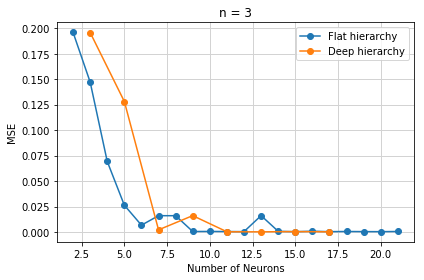

In [2]:
plt.title("n = 3")
plt.xlabel("Number of Neurons")
plt.ylabel("MSE")
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.plot(neurons_flat, minloss_flat, label='Flat hierarchy', marker='o')
plt.plot(neurons_deep, minloss_deep, label='Deep hierarchy', marker='o')
plt.tight_layout()
plt.legend()

#### 3. Interpretiere die Ergenisse für höhere Eingabedimensionen
Nachdem die Neuronenzahl, so gewählt wurde, dass sie Gleichung 5 entspricht, wird der Fehler meist nicht mehr kleiner. Manchmal (z.B. n=4) findet nochmal eine Minimierung statt, wenn man ein Neuron pro Schicht mehr nimmt, als Gleichung 5 angibt.  
Gleichung 5 scheint also zu stimmen.